In [1]:
using Distributed
using BenchmarkTools
using Plots
using DRR

┌ Info: Precompiling DRR [b7cdf4c7-cd72-4265-95a4-eec1a441a985]
└ @ Base loading.jl:1423


In [2]:
# Read the volume
volume, ΔX, ΔY, ΔZ = read_dicom("../data/cxr"; pad=true)
grid = volume2grid(volume, ΔX, ΔY, ΔZ)

# Define the camera
center = Vec3(180., 180., -100)
camera = Camera(center)

# Define the detector plane
center = Vec3(180., 180., 500.)
normal = Vec3(1., -1., -1.)
height, width = 601, 601
Δx, Δy = 2., 2.
detector = Detector(center, normal, height, width, Δx, Δy)

# Generate the DRR
spacing = 0.75

0.75

In [3]:
function make_drr1(grid, volume, camera, detector, spacing)

    # Set up the detector plane
    plane = make_plane(detector)
    projector = get_rays(camera, plane)

    # Trace rays through the voxel grid
    drr = Array{Float64}(undef, length(projector))
    for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, volume)
    end
    drr = reshape(drr, (height, width))
    return drr

end

make_drr1 (generic function with 1 method)

In [4]:
function make_drr2(grid, volume, camera, detector, spacing)

    # Set up the detector plane
    plane = make_plane(detector)
    projector = get_rays(camera, plane)

    # Trace rays through the voxel grid
    drr = Array{Float64}(undef, length(projector))
    @distributed for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, volume)
    end
    drr = reshape(drr, (height, width))
    return drr

end

make_drr2 (generic function with 1 method)

In [ ]:
function make_drr3(grid, volume, camera, detector, spacing)

    # Set up the detector plane
    plane = make_plane(detector)
    projector = get_rays(camera, plane)

    # Trace rays through the voxel grid
    drr = Array{Float64}(undef, length(projector))
    for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, volume, use_gpu=true)
    end
    drr = reshape(drr, (height, width))
    return drr

end

In [ ]:
function make_drr4(grid, volume, camera, detector, spacing)

    # Set up the detector plane
    plane = make_plane(detector)
    projector = get_rays(camera, plane)

    # Trace rays through the voxel grid
    drr = Array{Float64}(undef, length(projector))
    @distributed for i in 1:length(projector)
        ray = projector[i]
        drr[i] = raytrace_trilinear(ray, spacing, grid, volume, use_gpu=true)
    end
    drr = reshape(drr, (height, width))
    return drr

end

In [ ]:
# rang = vcat(0.01:0.01:0.09, 0.1:0.1:0.5, 0.75);
rang = vcat(0.1:0.1:0.5, 0.75)
smp = length(rang)

benchtimes_cpu_serial = Array{Float64}(undef, smp)
benchtimes_cpu_parallel = Array{Float64}(undef, smp)
benchtimes_gpu_serial = Array{Float64}(undef, smp)
benchtimes_gpu_parallel = Array{Float64}(undef, smp)

for i = 1:smp
    # Generate the DRR
    spacing = rang[i]
    benchtimes_cpu_serial[i] = @elapsed make_drr1(grid, volume, camera, detector, spacing)
    benchtimes_cpu_parallel[i] = @elapsed make_drr2(grid, volume, camera, detector, spacing)
    benchtimes_gpu_serial[i] = @elapsed make_drr3(grid, volume, camera, detector, spacing)
    benchtimes_cpu_parallel[i] = @elapsed make_drr4(grid, volume, camera, detector, spacing)
end

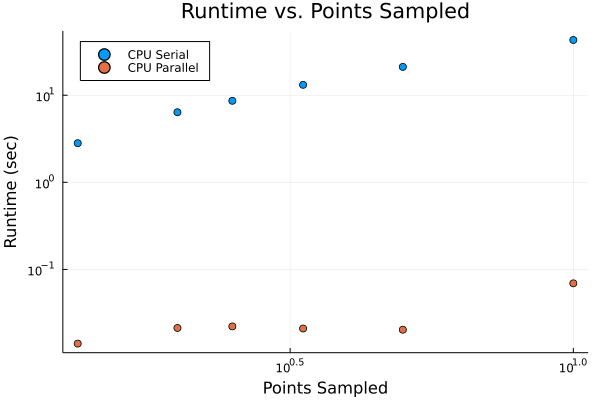

In [11]:
scatter(1 ./ rang, benchtimes_cpu_serial, legend=:topleft, xaxis=:log, yaxis=:log, 
    xlabel="Points Sampled", ylabel="Runtime (sec)", 
    title="Runtime vs. Points Sampled", label="CPU Serial")
scatter!(1 ./ rang, benchtimes_cpu_parallel, legend=:topleft, xaxis=:log, yaxis=:log, 
    xlabel="Points Sampled", ylabel="Runtime (sec)", 
    label="CPU Parallel")
scatter!(1 ./ rang, benchtimes_cpu_serial, legend=:topleft, xaxis=:log, yaxis=:log, 
    xlabel="Points Sampled", ylabel="Runtime (sec)", 
    label="GPU Serial")
scatter!(1 ./ rang, benchtimes_gpu_parallel, legend=:topleft, xaxis=:log, yaxis=:log, 
    xlabel="Points Sampled", ylabel="Runtime (sec)", 
    label="GPU Parallel")